In [2]:
import pickle
import random
import torch.backends.cudnn as cudnn
import os
import glob
import time
import sys
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from CloudDataset import CloudDataset
from torchvision import transforms
import segmentation_models_pytorch as smp
import torch.multiprocessing as mp
import torch.optim as optim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torchinfo import summary
from CloudDataset import CloudDataset
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")                                                                                                                        
print(device)

cuda


In [3]:
from collections import OrderedDict
import torch

ckpt_pth = './models/PSPNet_timm-efficientnet-b0_exp0_stationary_1751360408.pth'
ckpt_dst = './models/PSPNet_timm-efficientnet-b0_cloud_model.pth'

def remove_module(ckpt):
    new_state_dict = OrderedDict()
    for k, v in ckpt.items():
        name = k[7:] # remove module.
        new_state_dict[name] = v
    return new_state_dict

#ckpt = torch.load(ckpt_pth, map_location=torch.device('cpu'))
#ckpt['model_state_dict'] = remove_module(ckpt['model_state_dict'])
#torch.save(ckpt, ckpt_dst)


In [4]:
config_fn = "/scratch3/BMC/gpu-ghpcs/Rey.Koki/Cloud_Top_Temp/deep_learning/configs/pspnet_efficientnet-b0_exp0_stationary.json"

with open(config_fn) as fn:
    cfg = json.load(fn)
arch = cfg['architecture']
encoder = cfg['encoder']
lr = cfg['lr']
data_fn = cfg['datapointer']
with open(data_fn, 'rb') as handle:
    data_dict = pickle.load(handle)
    
data_transforms = transforms.Compose([transforms.ToTensor()])
test_set = CloudDataset(data_dict['test'], data_transforms)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=1, shuffle=True, drop_last=True)

In [5]:
arch = cfg['architecture']
encoder = cfg['encoder']
lr = cfg['lr']
model = smp.create_model( # create any model architecture just with parameters, without using its class
        arch=arch,
        encoder_name=encoder,
        encoder_weights=None,
        in_channels=3, # model input channels
        classes=3 # model output channels
)


chkpt = torch.load(ckpt_dst, map_location=torch.device(device))
model = model.to(device)
model.load_state_dict(chkpt['model_state_dict'])
model.eval()
torch.set_grad_enabled(False)

In [6]:
def print_iou(truth, pred):
    intersection = (pred + truth == 2).sum()
    union = (pred + truth >= 1).sum()
    print(intersection/union)
    
    
def plot_data_truth_pred(data, truth, pred):
    
    fig, axs = plt.subplots(4,3, figsize=(9,12))
    axs[0][0].imshow(data[:,:,0])
    axs[0][1].imshow(data[:,:,1])
    axs[0][2].imshow(data[:,:,2])    
    axs[1][0].imshow(data)
    axs[1][1].imshow(truth[:,:,0]+truth[:,:,1]+truth[:,:,2])
    axs[1][2].imshow(pred[:,:,0]+pred[:,:,1]+pred[:,:,2])
    axs[2][0].imshow(truth[:,:,0])
    axs[2][1].imshow(truth[:,:,1])
    axs[2][2].imshow(truth[:,:,2])
    axs[3][0].imshow(pred[:,:,0])
    axs[3][1].imshow(pred[:,:,1])
    axs[3][2].imshow(pred[:,:,2])
    axs[0][0].set_title('C14')
    axs[0][1].set_title('C15')
    axs[0][2].set_title('C16')
    axs[1][0].set_title('data')
    axs[1][1].set_title('truth')
    axs[1][2].set_title('model prediction')
    
    axs[2][0].set_ylabel('truth')
    axs[2][0].set_title('low')
    axs[2][1].set_title('med')
    axs[2][2].set_title('high')

    axs[3][0].set_ylabel('model prediction')
    axs[3][0].set_title('low')
    axs[3][1].set_title('med')
    axs[3][2].set_title('high')

    for ax in np.ravel(axs):
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.tight_layout()
    plt.savefig('result.png', dpi=300)
    
    plt.show() 

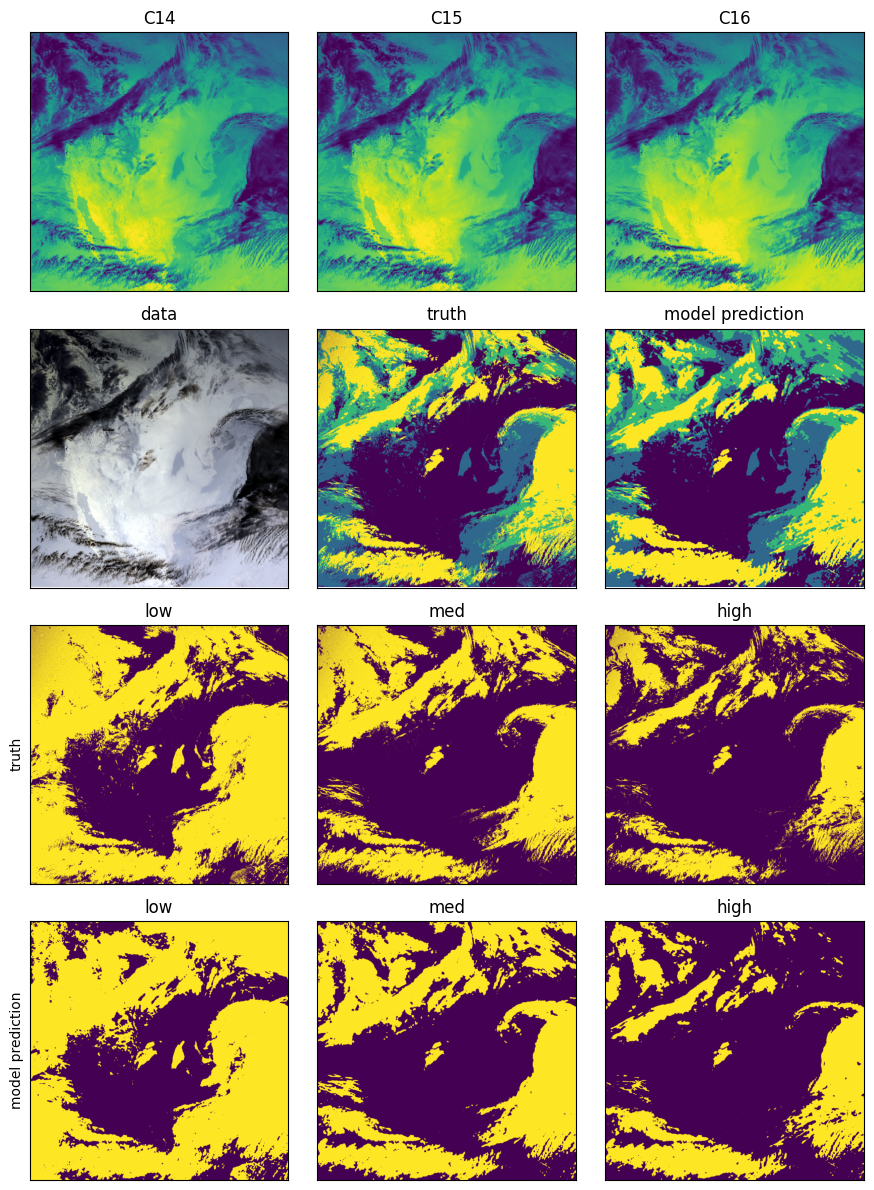

0.8011451609798221


In [7]:
for data in test_loader:
    batch_data, batch_labels = data
    batch_data, batch_labels = batch_data.to(device, dtype=torch.float), batch_labels.to(device, dtype=torch.float)
    pred = model(batch_data)
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5) * 1
    pred = np.einsum('ijk->jki', pred.cpu().numpy().squeeze(0))
    data = np.einsum('ijk->jki', batch_data.cpu().numpy().squeeze(0)) 
    truth = np.einsum('ijk->jki', batch_labels.cpu().numpy().squeeze(0)) 

    plot_data_truth_pred(data, truth, pred)
    print_iou(truth, pred)
    
    break

In [8]:
feats = model.encoder(batch_data)
deep_feat = feats[-1]
pooled = deep_feat.mean(dim=(2, 3))

In [9]:
high_mask = pred[:,:,2]
low_mask = pred[:,:,0]

In [9]:
from scipy.ndimage import label, generate_binary_structure
import skimage.measure

s = generate_binary_structure(2,2)

In [10]:
labeled_array, num_features = label(high_mask, structure=s)

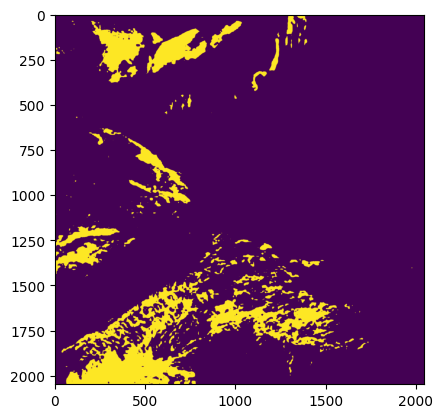

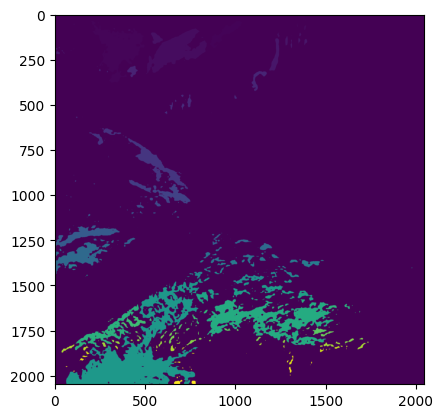

In [11]:
plt.imshow(high_mask)
plt.show()
plt.imshow(labeled_array)
plt.show()

In [12]:
labeled_array[labeled_array>1]=1

415
9


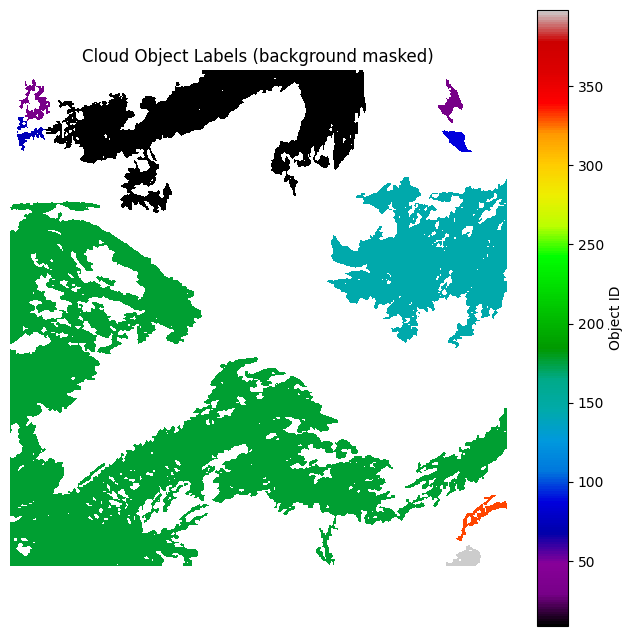

In [13]:
labeled_array, num_features = label(low_mask, structure=s)
props = skimage.measure.regionprops(labeled_array)
keep_ids = [p.label for p in props if p.area > 5000]  # or whatever threshold
filtered = np.isin(labeled_array, keep_ids) * labeled_array
print(num_features)
print(len(keep_ids))
masked = np.ma.masked_where(filtered == 0, filtered)
plt.figure(figsize=(8, 8))
plt.imshow(masked, cmap='nipy_spectral', interpolation='none')
plt.title('Cloud Object Labels (background masked)')
plt.axis('off')
plt.colorbar(label='Object ID')
plt.show()

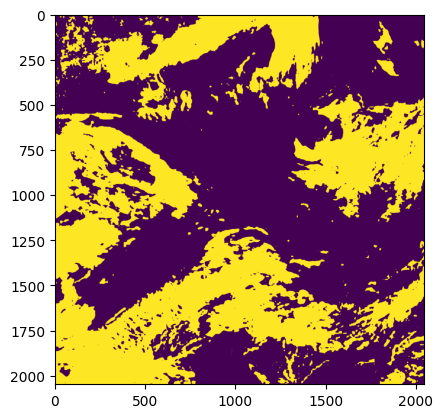

In [14]:
plt.imshow(low_mask)
plt.show()

In [45]:
from einops import rearrange

# Assume x: (C, 2048, 2048)
def extract_patches(x, patch_size=128):
    x = np.transpose(x, (2, 0, 1))  # or x.permute(2, 0, 1) if torch tensor
    patches = rearrange(
        x, 'c (h ph) (w pw) -> (h w) c ph pw', ph=patch_size, pw=patch_size
    )
    return patches  # shape: (256, C, 128, 128)

data_patches = extract_patches(data)
pred_patches = extract_patches(pred)
truth_patches = extract_patches(truth)
data_patches.shape

(256, 3, 128, 128)

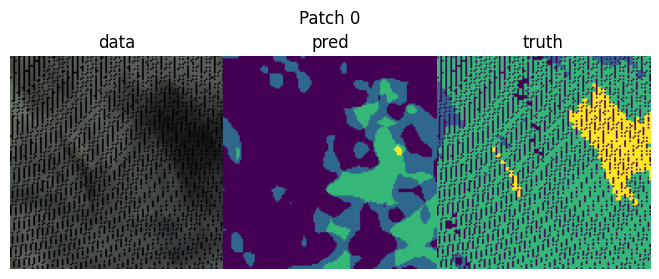

441
10551
1442
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
4061
3704
73
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


In [133]:
for n in range(0,len(data_patches)):
#n = 20
    data_patch = data_patches[n]  # shape: (3, 128, 128)
    pred_patch = pred_patches[n]  # shape: (3, 128, 128)
    truth_patch = truth_patches[n]  # shape: (3, 128, 128)
    
    data_patch_img = data_patch.transpose(1, 2, 0)
    pred_patch_img = pred_patch.transpose(1, 2, 0)
    truth_patch_img = truth_patch.transpose(1, 2, 0)
    fig, axs = plt.subplots(1,3)
    axs[0].imshow(data_patch_img[:,:,0])
    axs[0].imshow(data_patch_img)

    axs[1].imshow(np.sum(pred_patch_img,axis=2))

    axs[2].imshow(truth_patch_img[:,:,0]+truth_patch_img[:,:,1]+truth_patch_img[:,:,2])
    axs[2].imshow(np.sum(truth_patch_img,axis=2))
    axs[0].set_title('data')
    axs[1].set_title('pred')
    axs[2].set_title('truth')
    plt.suptitle("Patch {}".format(n), y=0.8)
    
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    plt.tight_layout(pad=0)  # remove padding around figure
    plt.show()

    truth_sum = np.sum(truth_patch_img,axis=2)
    print(np.sum(truth_sum ==1))
    print(np.sum(truth_sum ==2))
    print(np.sum(truth_sum ==3))

    
    print(pred_patch_img[:,:,0])
    print(pred_patch_img[:,:,1])
    print(pred_patch_img[:,:,2])
    print(np.sum(pred_patch_img[:,:,0]))
    print(np.sum(pred_patch_img[:,:,1]))
    print(np.sum(pred_patch_img[:,:,2]))
    print(np.sum(pred_patch_img,axis=2))
    break
    

In [144]:
plt.imshow(cloud_dataset['class_mask'][0].permute(1, 2, 0).cpu())
plt.show()

TypeError: list indices must be integers or slices, not str

In [171]:
from torch.utils.data import Dataset, DataLoader

from torch.utils.data import Dataset
from einops import rearrange
import torch

class PatchDataset(Dataset):
    def __init__(self, image_tensor, pred_tensor, patch_size=128, cloud_thresh=0):
        """
        image_tensor: torch.Tensor of shape (C, H, W)
        pred_tensor:  torch.Tensor of shape (T, H, W), thermometer encoded (e.g., T=3)
        """
        assert image_tensor.ndim == 3
        assert pred_tensor.ndim == 3
        C, H, W = image_tensor.shape
        T = pred_tensor.shape[0]
        assert pred_tensor.shape[1:] == (H, W)

        # Rearrange to patchwise shape
        image_patches = rearrange(image_tensor, 'c (h ph) (w pw) -> (h w) c ph pw', ph=patch_size, pw=patch_size)
        pred_patches  = rearrange(pred_tensor, 't (h ph) (w pw) -> (h w) t ph pw', ph=patch_size, pw=patch_size)

        # Grid indices
        grid_h = H // patch_size
        grid_w = W // patch_size
        all_indices = [(i, j) for i in range(grid_h) for j in range(grid_w)]

        valid_patches = []
        valid_preds = []
        valid_indices = []
        cloud_hists = []

        for patch, pred_patch, (i, j) in zip(image_patches, pred_patches, all_indices):
            # Determine cloud class map from thermometer encoding
            summed = pred_patch.sum(dim=0).long()  # values: 0=no cloud, 1=low, 2=mid, 3=high
            #print(summed)

            class_map = (summed).clamp(min=0, max=3)  # now: 0=low, 1=mid, 2=high
            
            cloud_pixels = (summed > 0).sum().item()  # number of cloud pixels
            #print(cloud_pixels)

            if cloud_pixels < cloud_thresh:
                continue  # skip low-cloud patches

            #plt.imshow(pred_patch.permute(1, 2, 0).cpu())
            #plt.show()
            
            # Compute histogram
            hist = torch.stack([
                (class_map == 1).sum(),  # low
                (class_map == 2).sum(),  # mid
                (class_map == 3).sum(),  # high
            ]).float()
 
            hist /= class_map.numel()  # normalize
            valid_patches.append(patch)
            valid_preds.append(pred_patch)
            valid_indices.append((i, j))
            cloud_hists.append(hist)
            #break

        self.patches = torch.stack(valid_patches)
        self.pred_patches = torch.stack(valid_preds)
        self.cloud_hist = torch.stack(cloud_hists)
        self.indices = valid_indices
        self.patch_size = patch_size

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        row, col = self.indices[idx]
        return {
            'image': self.patches[idx],            # (C, ph, pw)
            'class_mask': self.pred_patches[idx],  # (T, ph, pw)
            'hist': self.cloud_hist[idx],          # (3,)
            'row': row,
            'col': col,
        }





d = torch.from_numpy(data).permute(2, 0, 1).float()
d = d.to(device)
print(pred.shape)
p = torch.from_numpy(truth).permute(2, 0, 1).float()
p = p.to(device)
cloud_dataset = PatchDataset(d, p)
print(len(cloud_dataset))
latent_loader = torch.utils.data.DataLoader(dataset=cloud_dataset, batch_size=1, shuffle=False, drop_last=True)

(2048, 2048, 3)
256


torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([128, 128, 3])
tensor([0.0269, 0.6440, 0.0880], device='cuda:0')


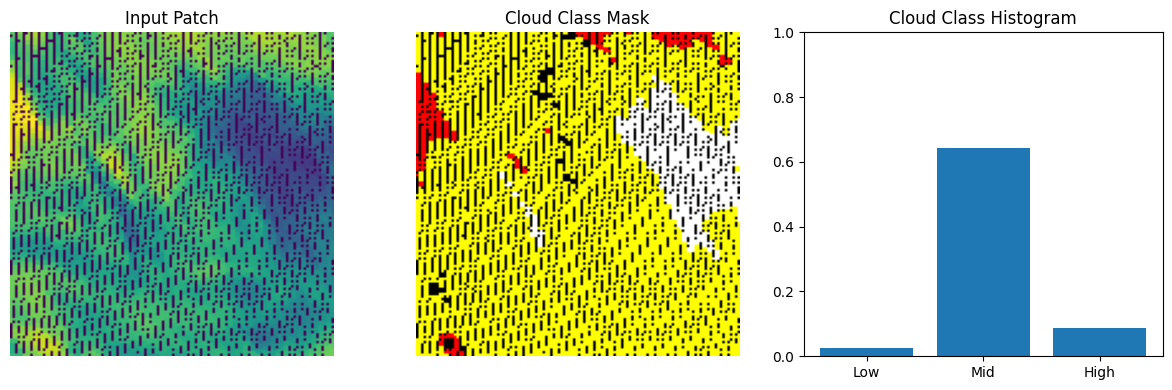

In [172]:
patch_idx=0
for batch in latent_loader:
    imgs = batch['image']         # shape: (B, C, 128, 128)
    hists = batch['hist']         # shape: (B, 3)
    class_masks = batch['class_mask']  # shape: (B, T, 128, 128)
    imgs = batch['image'][patch_idx]         # (C, 128, 128)
    hists = batch['hist'][patch_idx]         # (3,)
    class_mask = batch['class_mask'][patch_idx]  # (T, 128, 128)
    print(imgs.shape)
    print(class_mask.shape)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    
    # Image
    #axs[0].imshow(imgs.permute(1, 2, 0).cpu(), cmap='viridis')
    print(imgs.permute(1, 2, 0).shape)
    axs[0].imshow(imgs[1].cpu(), cmap='viridis')
    axs[0].set_title('Input Patch')
    axs[0].axis('off')

    # Cloud class mask (argmax over T channels)
    axs[1].imshow(class_mask.permute(1, 2, 0).cpu(), cmap='plasma')
    axs[1].set_title('Cloud Class Mask')
    axs[1].axis('off')

    # Histogram
    print(hists)
    axs[2].bar(['Low', 'Mid', 'High'], hists.cpu().numpy())
    axs[2].set_ylim(0, 1)
    axs[2].set_title('Cloud Class Histogram')

    plt.tight_layout()
    plt.show()

    break

In [173]:
latent_features = []
hist_features = []
for batch in latent_loader:
    imgs = batch['image']         # shape: (B, C, 128, 128)
    hists = batch['hist']         # shape: (B, 3)
    class_masks = batch['class_mask']  # shape: (B, T, 128, 128)

    feats = model.encoder(imgs)
    deep_feat = feats[-1]
    pooled = deep_feat.mean(dim=(2, 3))
    latent_features.append(pooled)
    hist_features.append(hists)

In [174]:
from sklearn.preprocessing import StandardScaler


latent_feats = torch.cat(latent_features, dim=0)
hist_feats = torch.cat(hist_features, dim=0)
# Combine and normalize your features before plotting
combined_feats = np.concatenate([latent_feats.cpu(), hist_feats.cpu()], axis=1)
combined_feats = StandardScaler().fit_transform(combined_feats)


In [175]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(combined_feats)

In [176]:

def visualize_cluster_grid(cluster_labels, image_shape=(2048, 2048), patch_size=128, cmap='tab10'):
    """
    cluster_labels: (N,) array from KMeans (e.g., length 256 for 16x16 grid)
    image_shape: tuple (H, W), e.g., (2048, 2048)
    patch_size: int, default 128
    cmap: matplotlib colormap (e.g., 'tab10', 'nipy_spectral', 'viridis')
    """

    H, W = image_shape
    grid_h = H // patch_size
    grid_w = W // patch_size

    assert cluster_labels.shape[0] == grid_h * grid_w, "Label count doesn't match patch grid size"

    # Reshape to 2D grid
    cluster_map = cluster_labels.reshape(grid_h, grid_w)

    # Display
    plt.figure(figsize=(6, 6))
    plt.imshow(cluster_map, cmap=cmap, interpolation='nearest')
    plt.title("Clustered Cloud Regimes")
    plt.axis('off')
    plt.colorbar(label='Cluster ID')
    plt.show()
    return cluster_map


def visualize_sparse_cluster_grid(cluster_labels, patch_indices, image_shape, patch_size=128, cmap='tab10'):
    """
    cluster_labels: (M,) cluster assignment per patch
    patch_indices: list of (row, col) tuples
    image_shape: (H, W) of original image
    """
    H, W = image_shape
    grid_h = H // patch_size
    grid_w = W // patch_size

    cluster_map = np.full((grid_h, grid_w), fill_value=-1, dtype=int)

    for (r, c), label in zip(patch_indices, cluster_labels):
        cluster_map[r, c] = label

    # Mask background for plotting
    plt.figure(figsize=(8, 8))
    cmap_obj = plt.get_cmap(cmap)
    cmap_obj.set_bad(color='black')  # set missing patches to black
    plt.imshow(np.ma.masked_where(cluster_map == -1, cluster_map), cmap=cmap_obj)
    plt.colorbar(label='Cluster ID')
    plt.title("Sparse Cloud Regime Cluster Map")
    plt.axis('off')
    plt.show()

    return cluster_map

In [177]:
data.shape[:2]

(2048, 2048)

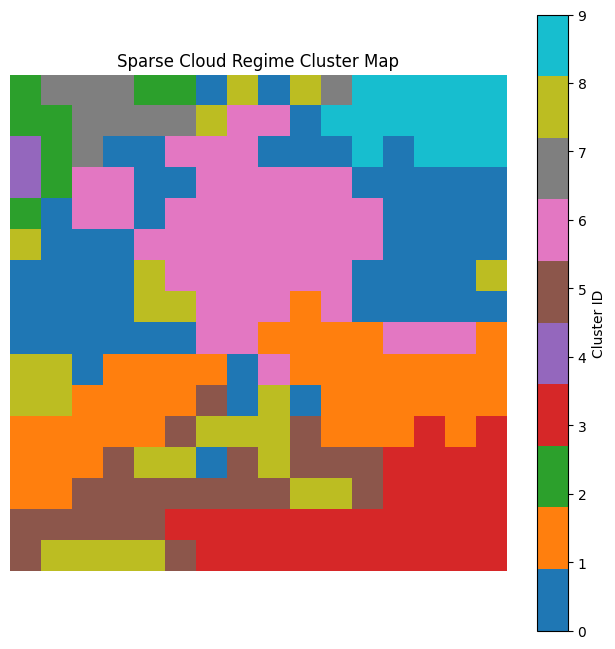

In [178]:
cluster_map = visualize_sparse_cluster_grid(
    cluster_labels=cluster_labels,
    patch_indices=cloud_dataset.indices,
    image_shape=data.shape[:2],  # (H, W)
    patch_size=128
)
#cluster_map = visualize_cluster_grid(cluster_labels)

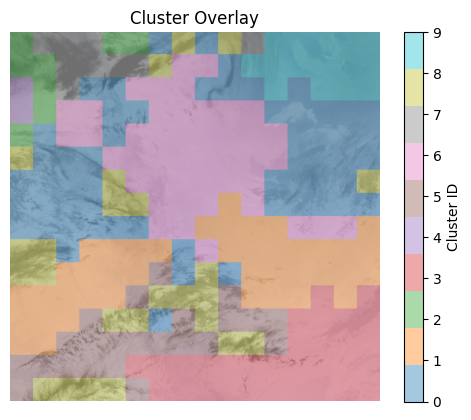

In [179]:
def sparse_cluster_grid(cluster_labels, valid_indices, image_shape, patch_size):
    H, W = image_shape
    grid_h, grid_w = H // patch_size, W // patch_size
    cluster_map = np.full((grid_h, grid_w), fill_value=-1)  # -1 = background

    for label, (i, j) in zip(cluster_labels, valid_indices):
        cluster_map[i, j] = label

    return cluster_map
patch_size=128
upsampled = np.kron(cluster_map, np.ones((patch_size, patch_size)))

# Mask background (where cluster ID == -1)
masked_overlay = np.ma.masked_where(upsampled == -1, upsampled)

plt.imshow(data, cmap='gray', alpha=0.6)
plt.imshow(masked_overlay, cmap='tab10', alpha=0.4)
plt.colorbar(label="Cluster ID")
plt.title("Cluster Overlay")
plt.axis('off')
plt.show()



In [180]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

def plot_umap(features, labels=None, n_neighbors=15, min_dist=0.1, title="UMAP of Patch Features"):
    """
    features: (N, D) numpy array of feature vectors
    labels: (N,) optional cluster labels or class labels to color by
    """
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    embedding = reducer.fit_transform(features)

    plt.figure(figsize=(8, 6))
    if labels is not None:
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='tab10', s=20, linewidth=0)
        plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.7)
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.tight_layout()
    plt.show()

/scratch3/BMC/gpu-ghpcs/Rey.Koki/miniconda/envs/cloud/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


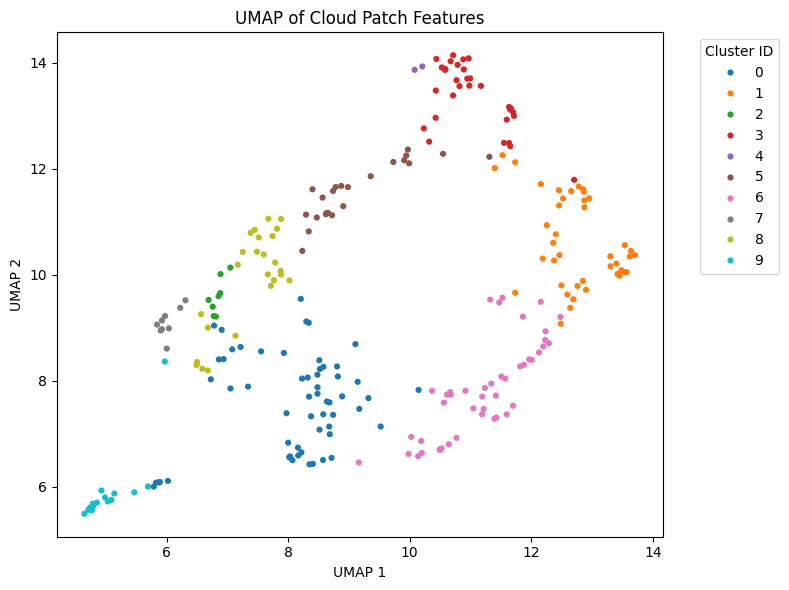

In [181]:
# Visualize
plot_umap(combined_feats, labels=cluster_labels, title="UMAP of Cloud Patch Features")


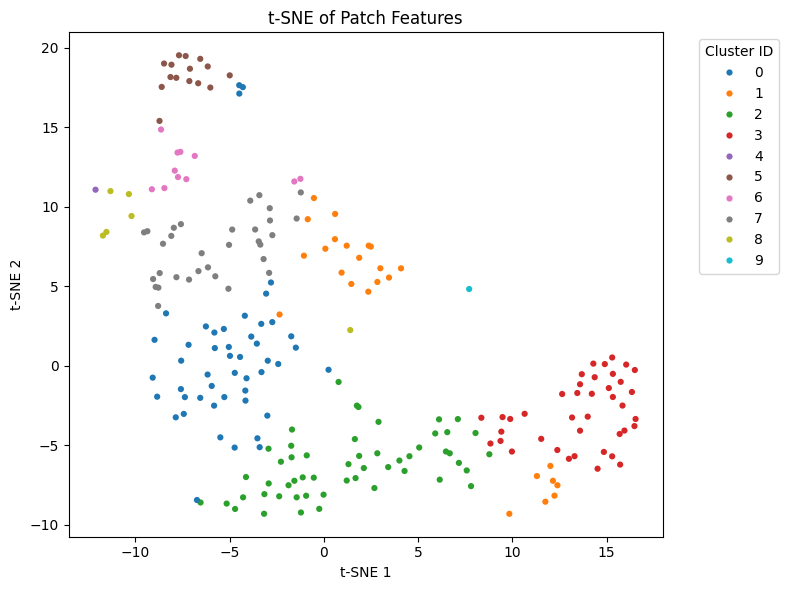

In [169]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne(features, labels=None, title="t-SNE of Patch Features"):
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    embedding = tsne.fit_transform(features)

    plt.figure(figsize=(8, 6))
    if labels is not None:
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='tab10', s=20, linewidth=0)
        plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.scatter(embedding[:, 0], embedding[:, 1], s=5, alpha=0.7)
    plt.title(title)
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.tight_layout()
    plt.show()


plot_tsne(combined_feats, labels=cluster_labels)    